# Milestone Project 2: SkimLit 🔥

The purpose of this notebook is to build an NLP model to make reading abstracts easier.

The paper we're repllicating (the source of the dataset that we'll be using) is available: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecutre  that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

If you want to find the groud truth for this notebook, see GitHub

## Confirm access to a GPU


In [1]:
!nvidia-smi

Mon May 22 16:56:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data

Since we'll be replicating the paper above(PubMed 200k RCT), let's download the dataset they used.
We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 14.68 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ 

dev.txt  test.txt  train.txt


In [4]:
# start our experiments using the 20k dataset with numbers replaced by the at signs
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [5]:
#check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to..

> Visualize Visualize Visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args: 
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.  
  """
  with open(filename, "r") as f:
    return f.readlines()


In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines within training files
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
test_lines = get_lines(data_dir + "test.txt")

In [10]:
dev_lines = get_lines(data_dir + "dev.txt")

The dataset is divided into different batches which each have a Objective, Methods, Results and Conclusion subparts

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines': 11}]
```  

In [11]:
train_lines[1]

'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'

In [12]:
#to create a preprocessing function which gives us dictionaries like the one above
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" #create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  #loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if it is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the line is an ID line
    elif line.isspace(): #check to see if the line  is an empty space, i.e. \n
      abstract_line_split = abstract_lines.splitlines() #split abstract into separat lines

      #iterate through each line in a single abstract and count them as the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split the target label from text using the \t escape sequence
        line_data["target"] = target_text_split[0] #get the target label
        line_data["text"] = target_text_split[1].lower() #get the tect and lowercase it
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)



    else: # if the above conditions are not fulfilled, the lines contains a label sentence
      abstract_lines += line

  return abstract_samples   

In [13]:
#get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 305 ms, sys: 87.5 ms, total: 392 ms
Wall time: 397 ms


(180040, 30212, 30135)

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualise it

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

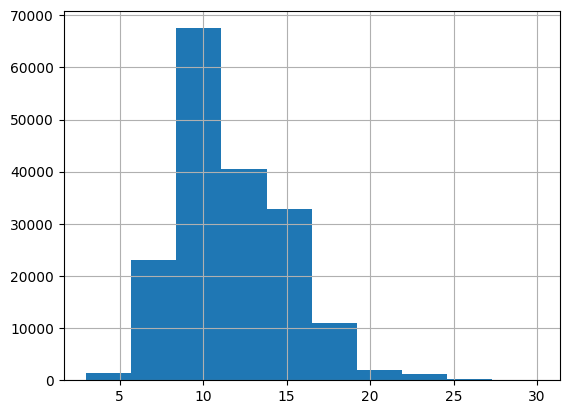

In [17]:
#Let's check the length of different lines
train_df.total_lines.hist();

### Get list of sentences 

In [18]:
#convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models require numbers)

OneHotEncode labels

In [19]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))


#check what does our data look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

Label Encode labels

In [21]:
#extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

#look at the labels 
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
#get the classes back fromm the label encoded arrys
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Starting a series of Modelling experiments....

As usual, we're going to be trying a bunch of different models and seeing which one works best

We're going to start with a baseline(TF-IDF Multinomial Naive Bayes classifier).



### Model 0: Getting a baseline
The base model is a TF-IDF Multinomial Naive Bayes

In [23]:
from scipy.special import yve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#fit the pipeline to training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
#Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [25]:
#make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds


array([4, 1, 3, ..., 4, 4, 1])

### Download the helper funciton script 

In the previous module, we wrote a fucntion to compare accuracy, precisoin, recall and f1-score. Rather than writing it again, let's downlaod if from our helper funciton script

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-22 16:57:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-22 16:57:20 (121 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
from helper_functions import calculate_results

In [28]:
#Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our dataset for deep sequence models

Before we start building deep models, we've got to create vectorization and embedding layers.

In [29]:
import numpy as np
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences] #splits each sentence into tokens and counts the number of tokens
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

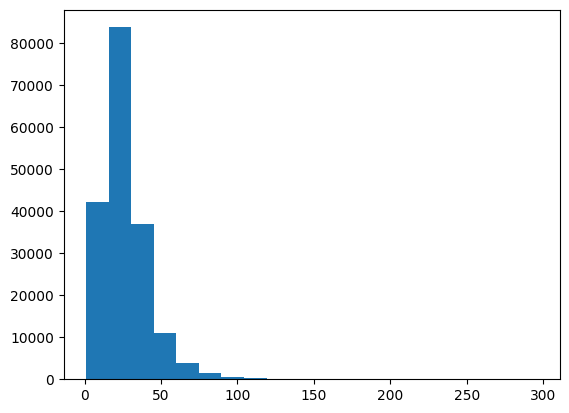

In [30]:
# what's the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [31]:
# how long of a sequence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
#maximum sequence length in training set
max(sent_lens)

296

### Create text vectorizer layer
We want to make a layer which maps our texts fromm words to numbers

In [33]:
#how many words in out vocab? (taken from table 2 in our paper)
max_tokens = 68000

In [34]:
#create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, #number of words in vacabulary
                                   output_sequence_length = output_seq_len) #desired output length of vectorized sequence


In [35]:
# Adapt text vectroizer to training sentences
text_vectorizer.adapt(train_sentences)


In [36]:
# Test out text_vectorizer on some random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectroized text: {text_vectorizer([target_sentence])}")

Text:
evidence of an association between c reactive protein and indoor pm@ @ among healthy adults in traffic-impacted areas is consistent with the hypothesis that traffic-related particles , even at relatively low concentrations , play an important role in the cardiovascular effects of the urban pm mixture .

Length of text: 47

Vectroized text: [[  299     4    26   423    30   243  3527   396     3  6511  2488   116
    247   266     5 28046  1272    20   905     7     2   930    28 24289
   6615   983    15  1523   220   341  1889    26   430   546     5     2
    323    71     4     2  2164  2488  3441     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Mos common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Mos common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Create custom text embedding


In [38]:
#create token embedding layer
token_embed = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab), #length of vocabulary
                                        output_dim = 128, #note: different embedding sizes result in drastically different numbers of parameters to train
                                        mask_zero = True, #helps with efficient computing if there are going to be a lot of zeros in the embedded tenso
                                        name = 'token_embedding')

In [39]:
#show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
embedded_sentence.shape

Sentence before vectorization:
 evidence of an association between c reactive protein and indoor pm@ @ among healthy adults in traffic-impacted areas is consistent with the hypothesis that traffic-related particles , even at relatively low concentrations , play an important role in the cardiovascular effects of the urban pm mixture .

Sentence after vectorization (before embedding):
 [[  299     4    26   423    30   243  3527   396     3  6511  2488   116
    247   266     5 28046  1272    20   905     7     2   930    28 24289
   6615   983    15  1523   220   341  1889    26   430   546     5     2
    323    71     4     2  2164  2488  3441     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.03410478 -0.01455486  0.02998686 ... -0.0015074   0.02178501
   -0.0073598 ]
  [ 0.01438275  0.01587906 -0.03952624 ...  0.03009308 -0.00442976
    0.04372189]
  [-0.00293984 -0.00743727  0.02817229 ...  0.03390375  0.03960747
    0.0441

TensorShape([1, 55, 128])

## Creating datasets(making sure our data loads as fast as possible)

we're going to setup our data to run as fast as possible with the TensorFlow tf.data API

* https://www.tensorflow.org/guide/data




In [40]:
# turn our data into tensorflow datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
#Take the TensorSliceDataset's and turn them inot prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [42]:
num_classes = len(label_encoder.classes_) 
num_classes

5

In [43]:
import tensorflow as tf
from tensorflow.keras import layers
#create 1D conv model to process sequences
#define the input layer
inputs = layers.Input(shape = (1,), dtype = tf.string)

#convert the inputs into vectors
text_vectors = text_vectorizer(inputs) #vectorize the inputs

#convert the vectors into embeddings
token_embeddings = token_embed(text_vectors) #create embedding


x = layers.Conv1D(64, 
                  kernel_size = 5, 
                  padding = "same", 
                  activation = 'relu')(token_embeddings)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)


#compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])



In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [45]:
#fit the model
history_1 = model_1.fit(train_dataset, 
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        epochs = 3,
                        validation_data = valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset)))# only 10% of 20k data

Epoch 1/3
562/562 [==============================] - 43s 58ms/step - loss: 0.9166 - accuracy: 0.6400 - val_loss: 0.6838 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6561 - accuracy: 0.7580 - val_loss: 0.6276 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6146 - accuracy: 0.7759 - val_loss: 0.5926 - val_accuracy: 0.7839


In [46]:
#Evaluate on whole validaiton dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5943 - accuracy: 0.7873


[0.5942664742469788, 0.7873361706733704]

In [47]:
#Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.5219964e-01, 1.6876344e-01, 6.1324269e-02, 2.9205376e-01,
         2.5658909e-02],
        [4.3109119e-01, 2.9950449e-01, 1.3914274e-02, 2.4571456e-01,
         9.7754896e-03],
        [1.6426826e-01, 7.9915943e-03, 1.6290692e-03, 8.2606864e-01,
         4.2466683e-05],
        ...,
        [1.1712020e-05, 8.8611286e-04, 1.0342739e-03, 6.0898878e-06,
         9.9806184e-01],
        [5.1291104e-02, 4.7554886e-01, 8.4236130e-02, 5.9109274e-02,
         3.2981458e-01],
        [1.6271859e-01, 7.0256495e-01, 5.0294373e-02, 3.7038814e-02,
         4.7383238e-02]], dtype=float32),
 (30212, 5))

In [48]:
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [50]:
#calcualte model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.73361578180855,
 'precision': 0.7838801128717342,
 'recall': 0.7873361578180855,
 'f1': 0.7848699018485685}

##Model_2: feature extraction with pre trained token embeddings

Now let's use pre-trained word embeddings rom tensorflow hub, more specifically the universal sentence encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however we are going ot stick with the universal sentence encoder


In [51]:
#downlaod pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_entence_enocoder")

In [52]:
#Test out the pretrianed embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"random sentence:\n {random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}\n")
print(f"Length of sentence embedding:\n {len(use_embedded_sentence[0])}")


random sentence:
 there was no significant difference in operation time and intraoperative blood loss between groups ( p > @ ) .

Sentence after embedding:
 [[-0.03699963 -0.0578726   0.03499611  0.02499675  0.06637935 -0.03284314
  -0.01269653 -0.06404342 -0.00985397  0.05362479  0.07609416 -0.03875465
   0.02339128  0.04631951  0.03796144 -0.00507004 -0.04264878 -0.0671046
  -0.02714312 -0.01977282  0.03208129  0.07905608  0.01008341 -0.00807248
  -0.03152831  0.03985255 -0.03611464  0.05740051  0.01379104 -0.02494334
   0.00950845 -0.01983561 -0.02117633  0.01866251 -0.03377329 -0.05373808
  -0.00016065 -0.05292648 -0.02933813  0.07225347 -0.04025949 -0.00846416
   0.01323149  0.04903492 -0.03125956  0.03076879 -0.03630091 -0.02880212
  -0.04972581 -0.04182274 -0.04326264 -0.08435322 -0.04790025 -0.00673734
   0.05322163  0.03411456 -0.01123889 -0.00485389  0.0605199  -0.02976772
  -0.0796809   0.04082897  0.08623529 -0.00085391  0.01565952 -0.05515447
  -0.02014619 -0.04106673  0.0

## Building and fitting an NLP feature extraction model using pretrained mebeddings from TensorFlow Hub

In [53]:
#Define feature extraction model using TF Hub layer
inputs = layers.Input(shape = [],
                      dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text automatically and create sequence of each sequence(512 long)

x = layers.Dense(128, activation = 'relu')(pretrained_embedding)

outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_2 = tf.keras.Model(inputs,
                         outputs,
                         name = 'model_2_USE_feature_extractor')

#Compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [54]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_entence_enocoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
history_2 = model_2.fit(x = train_dataset,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        epochs = 3,
                        validation_data = valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9146 - accuracy: 0.6495 - val_loss: 0.7958 - val_accuracy: 0.6862
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7701 - accuracy: 0.7002 - val_loss: 0.7570 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7560 - accuracy: 0.7110 - val_loss: 0.7421 - val_accuracy: 0.7138


In [56]:
#evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7448 - accuracy: 0.7122


[0.7447993755340576, 0.7122004628181458]

In [57]:
#predict the results of the model_2
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.0536159e-01, 3.7305376e-01, 2.4585379e-03, 2.1067403e-01,
        8.4520672e-03],
       [3.2215601e-01, 5.1212424e-01, 3.7306715e-03, 1.5872945e-01,
        3.2596691e-03],
       [2.3187187e-01, 1.7631012e-01, 1.9543000e-02, 5.3103608e-01,
        4.1238919e-02],
       ...,
       [1.9205781e-03, 6.4076926e-03, 5.3651799e-02, 8.1558811e-04,
        9.3720436e-01],
       [3.7801187e-03, 4.4581659e-02, 1.8485880e-01, 1.2304728e-03,
        7.6554894e-01],
       [1.6763145e-01, 2.9167375e-01, 4.9195534e-01, 4.2514284e-03,
        4.4487949e-02]], dtype=float32)

In [58]:
#convert the prediction probabilites to predicitions
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [59]:
#calculate results from TF Hub pretrained embeddings
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.22004501522574,
 'precision': 0.7132147328034305,
 'recall': 0.7122004501522574,
 'f1': 0.7091645672749941}

## Model_3: Conv1D with character level embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar stpes for characters if we want ot use character level embedidngs


### We need to create a character level tokenizer

In [60]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [61]:
# make fucntion to split into characters
def split_chars(text):
  return " ".join(list(text))

#Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

't h e r e   w a s   n o   s i g n i f i c a n t   d i f f e r e n c e   i n   o p e r a t i o n   t i m e   a n d   i n t r a o p e r a t i v e   b l o o d   l o s s   b e t w e e n   g r o u p s   (   p   >   @   )   .'

In [62]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [63]:
# Split sequence level data splits into character -level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
# average character length?
char_lens= [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens


149.3662574983337

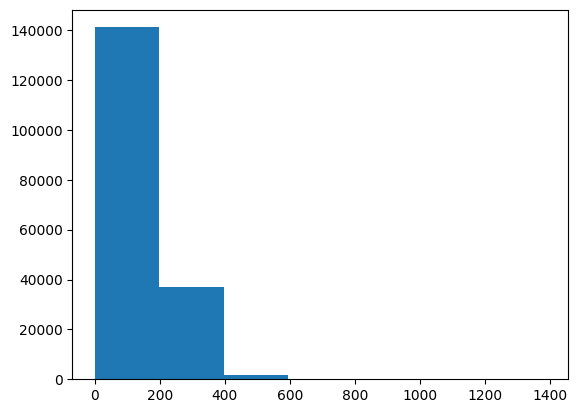

In [65]:
# check the distribution 
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7);

In [66]:
#find out what character length covers 95% of our data
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
len(alphabet)

68

In [69]:
num_char_tokens = len(alphabet) + 2 # add 2 for space and OOV token(out of vocabulary)

char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
                                    #standardize = None,
                                    output_sequence_length = output_seq_char_len,
                                    name = 'char_vectorizer')

In [70]:
#adapt character vectorizer to training character 
char_vectorizer.adapt(train_chars)

In [71]:
#chech character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different charcters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5least common characters: {char_vocab[-5:]}")


Number of different charcters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5least common characters: ['k', 'x', 'z', 'q', 'j']


In [72]:
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [73]:
list(alphabet)

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [74]:
set1 = set(list(alphabet))
set2 = set(char_vocab)

common_elements = set1.intersection(set2)

print(list(common_elements))

['e', 'k', 'c', 'f', 'o', 'l', 'h', 'x', 't', 'z', 'a', 'u', 'n', 's', 'm', 'p', 'w', 'i', 'b', 'j', 'd', 'q', 'g', 'v', 'r', 'y']


In [75]:
set1 - set2

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [76]:
# test our character vectorizer
random_train_chars = random.choice(train_chars)

print(f"charified text:\n {random_train_chars}\n")
print(f"Length of random_train_chars:\n {len(random_train_chars)}\n")
vectorized_chars = char_vectorizer(random_train_chars)
print(f"character vectorized text:\n {vectorized_chars}\n")
print(f"length of vectorized chars:\n {len(vectorized_chars)}\n")


charified text:
 c o n c e n t r a t i o n s   o f   g l o b o t r i a o s y l c e r a m i d e   (   g b @   )   ,   g l o b o t r i a o s y l s p h i n g o s i n e   (   l y s o - g b @   )   /   r e l a t e d   a n a l o g u e s   w e r e   i n v e s t i g a t e d   i n   p e d i a t r i c   a n d   a d u l t   f a b r y   c o h o r t s   .

Length of random_train_chars:
 327

character vectorized text:
 [11  7  6 11  2  6  3  8  5  3  4  7  6  9  7 17 18 12  7 22  7  3  8  4
  5  7  9 19 12 11  2  8  5 15  4 10  2 18 22 18 12  7 22  7  3  8  4  5
  7  9 19 12  9 14 13  4  6 18  7  9  4  6  2 12 19  9  7 18 22  8  2 12
  5  3  2 10  5  6  5 12  7 18 16  2  9 20  2  8  2  4  6 21  2  9  3  4
 18  5  3  2 10  4  6 14  2 10  4  5  3  8  4 11  5  6 10  5 10 16 12  3
 17  5 22  8 19 11  7 13  7  8  3  9  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0

## Creating  a character levle embedding

In [77]:
#create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), #number of different characters
                               output_dim = 25, #according to the paper
                               mask_zero = True,
                               name = "char_embed")



In [78]:
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Chars. (after vectorizartion and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text:
 c o n c e n t r a t i o n s   o f   g l o b o t r i a o s y l c e r a m i d e   (   g b @   )   ,   g l o b o t r i a o s y l s p h i n g o s i n e   (   l y s o - g b @   )   /   r e l a t e d   a n a l o g u e s   w e r e   i n v e s t i g a t e d   i n   p e d i a t r i c   a n d   a d u l t   f a b r y   c o h o r t s   .

Embedded Chars. (after vectorizartion and embedding):
 [[[ 0.04515285  0.00624514  0.01046697 ...  0.01528043 -0.02523071
    0.04433701]
  [ 0.01615698 -0.04365314 -0.04956952 ... -0.01560273 -0.0476341
    0.03831035]
  [-0.03029603 -0.04830838 -0.00247077 ... -0.00193353  0.0314842
    0.04481322]
  ...
  [ 0.0255098  -0.03528424  0.04684316 ... -0.00243648  0.00117251
   -0.03815969]
  [ 0.0255098  -0.03528424  0.04684316 ... -0.00243648  0.00117251
   -0.03815969]
  [ 0.0255098  -0.03528424  0.04684316 ... -0.00243648  0.00117251
   -0.03815969]]]
Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings

In [79]:
# make  Conv1D on chars only
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,
                  kernel_size = 5,
                  padding = 'same',
                  activation = 'relu')(char_embeddings)

x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(num_classes,
                       activation = 'softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)

#compile the model
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [80]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [81]:
#create tf.data datsets for character level embeddings
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
                                                        

In [82]:
#fit the model
history_3 = model_3.fit(x = train_char_dataset,
            steps_per_epoch = int(0.1*len(train_char_dataset)),
            epochs = 3,
            validation_data = val_char_dataset,
            validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2683 - accuracy: 0.4822 - val_loss: 1.0500 - val_accuracy: 0.5871
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0250 - accuracy: 0.5881 - val_loss: 0.9628 - val_accuracy: 0.6104
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9537 - accuracy: 0.6230 - val_loss: 0.8876 - val_accuracy: 0.6476


In [83]:
#make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset
                                     )
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.23797397, 0.3388372 , 0.07458393, 0.3345561 , 0.01404881],
       [0.1354793 , 0.6163369 , 0.03233612, 0.11934301, 0.09650467],
       [0.18102387, 0.27967244, 0.23774636, 0.25365043, 0.04790691],
       ...,
       [0.01564853, 0.01978078, 0.1161477 , 0.02103799, 0.82738495],
       [0.0178899 , 0.07335228, 0.6370481 , 0.02502372, 0.24668597],
       [0.3789364 , 0.47174722, 0.07778796, 0.06523761, 0.00629086]],
      dtype=float32)

In [84]:
#convert the probabilities into predictions
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 1])>

In [85]:
#calcualte results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results


{'accuracy': 64.25592479809347,
 'precision': 0.6377472478330682,
 'recall': 0.6425592479809348,
 'f1': 0.6282630972251373}

##Model 4: Combining pretrained token embeddings + characters embeddings( hybrid embedding layer)
1. Create a toke-level embedding model(similar to `model_1`)
2. Create a character-level model(similar to `model_3` with significant modification)
3. Combine 1&2 with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section4.2 of paper
5. Construct a model which takes tokens and character-level sequences as input and produces sequence label probabilities as outputs. 

In [86]:
# 1. Setup token inputs/nodel

token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,
                             activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)                              

In [87]:
#2, Setup char inputs/model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-LSTM layer as per the paper
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [88]:
#3. Concatenate token and char inputs(create hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                   char_model.output])

In [89]:
#4. create output layers - adding in dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout_layer = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout_layer)



In [90]:
#5. Construct model with char and token inouts
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embeddings')

In [91]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_entence_enocoder (Ke  (None, 512)         256797824   [

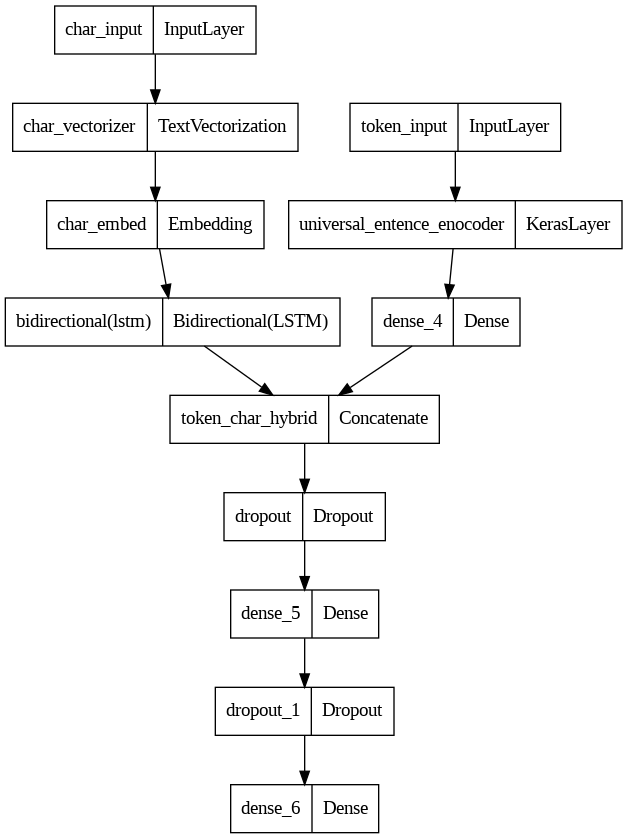

In [92]:
# plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4)

In [93]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

###Combining token and character embeddings into tf.data dataset

In [94]:
#combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

#prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
#combine chars and tokens into dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

#prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
#combine chars and tokens into dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

#prefetch and batch test data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
len(val_char_token_dataset)

945

### Fitting a model on token and character embedded input data

In [98]:
#Fit the model on tokens and chars
history_4 = model_4.fit(x = train_char_token_dataset,
                        steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                        epochs = 3,
                        validation_data = val_char_token_dataset,
                        validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 55ms/step - loss: 0.9840 - accuracy: 0.6091 - val_loss: 0.7704 - val_accuracy: 0.7108
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.8009 - accuracy: 0.6933 - val_loss: 0.7146 - val_accuracy: 0.7330
Epoch 3/3
562/562 [==============================] - 24s 44ms/step - loss: 0.7739 - accuracy: 0.7079 - val_loss: 0.6882 - val_accuracy: 0.7427


In [99]:
#evaluate the model on the whole valiation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.6921 - accuracy: 0.7360


[0.6920721530914307, 0.7359989285469055]

In [100]:
#calculate the prediction probabilities of validation data
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[4.5918834e-01, 3.4682643e-01, 3.7053770e-03, 1.8415405e-01,
        6.1257752e-03],
       [3.4862685e-01, 4.9421835e-01, 5.7388092e-03, 1.4841411e-01,
        3.0018822e-03],
       [3.2100624e-01, 1.2122555e-01, 7.4234866e-02, 4.4752944e-01,
        3.6003888e-02],
       ...,
       [8.2342618e-04, 9.1037173e-03, 5.1668081e-02, 3.2400471e-04,
        9.3808073e-01],
       [5.0123464e-03, 4.0340524e-02, 2.4883595e-01, 2.3661288e-03,
        7.0344508e-01],
       [3.3529899e-01, 4.1359657e-01, 1.8663022e-01, 2.5216876e-02,
        3.9257362e-02]], dtype=float32)

In [101]:
#calculate the predictions 
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [102]:
#calculate the results 
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 73.59989408182179,
 'precision': 0.7359068530068352,
 'recall': 0.7359989408182179,
 'f1': 0.732786821415469}

> **NOTE:** any engineered feature which we apply to out raining data, it should be applicable and available for the test data as well. In our case, line numbers and total lines are available.

### Create positional embeddings

In [103]:
train_df[:15]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [104]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

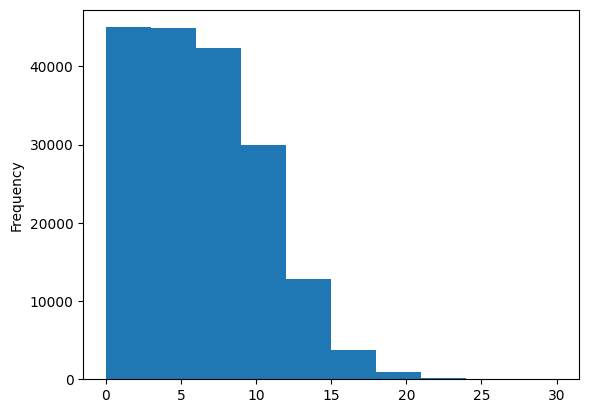

In [105]:
#distribution of line number column
train_df.line_number.plot.hist(
    
)

In [106]:
#Use TensorFLow to create one_hot_encoded tensors of our 'line_numbers' column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                        depth = 15)
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [107]:
#do the same for validation data
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                        depth = 15)
val_line_numbers_one_hot

<tf.Tensor: shape=(30212, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [108]:
#do the same for test data 
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                        depth = 15)
test_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Let's do the same for our total lines feature


In [109]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

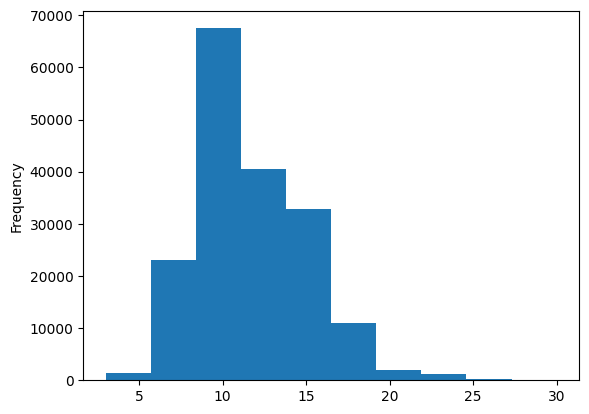

In [110]:
#check the distribution
train_df.total_lines.plot.hist()

In [111]:
np.percentile(train_df["total_lines"], 95)

18.0

In [112]:
#one hot encode the total lines feature for training data
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),
                                      depth = 20)

train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [113]:
#one hot encode the total lines feature for validation  data
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),
                                      depth = 20)

val_total_lines_one_hot

<tf.Tensor: shape=(30212, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [114]:
#one hot encode the total lines feature for testing data
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),
                                      depth = 20)

test_total_lines_one_hot

<tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

## Building a Tribid embedding model

1. Create a token level model
2. create a character level model
3. create a model for the " line_number" feature
4. create a model for the "total_lines" feature
5. combine the outputs of 1 and 2 using layers.Concatenate
6. Combine the outputs of 3, 4, 5 using layers.Concatenate
7. Create an output layer to accept the tribid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras.Model

In [203]:
1. #token_imputs
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu' )(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)


                                                

In [204]:
2. #char inputs
char_inputs = layers.Input(shape = (1, ), dtype = 'string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

In [205]:
3 #line number inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = 'line_number_input')
x = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                    outputs = x)


In [206]:
4 #total lines model
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.float32, name = 'total_lines_inputs')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)

In [207]:
5 #ombine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output,
                                                                                char_model.output])

In [208]:
#add the dropout layer
z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [209]:
6. # Combine positional embedding with combined token and char embeddings
tribid_embeddings = layers.Concatenate(name = 'char_token_positional_embedding')([z,
                                                                                   total_lines_model.output,
                                                                                  line_number_model.output])

In [210]:
7. #create output layer
output_layer = layers.Dense(5, 
                            activation = 'softmax',
                            name = 'output_layer')(tribid_embeddings)
                             

In [211]:
#put the model together
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = 'tribid_model')

In [212]:
model_5.summary()

Model: "tribid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_entence_enocoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']

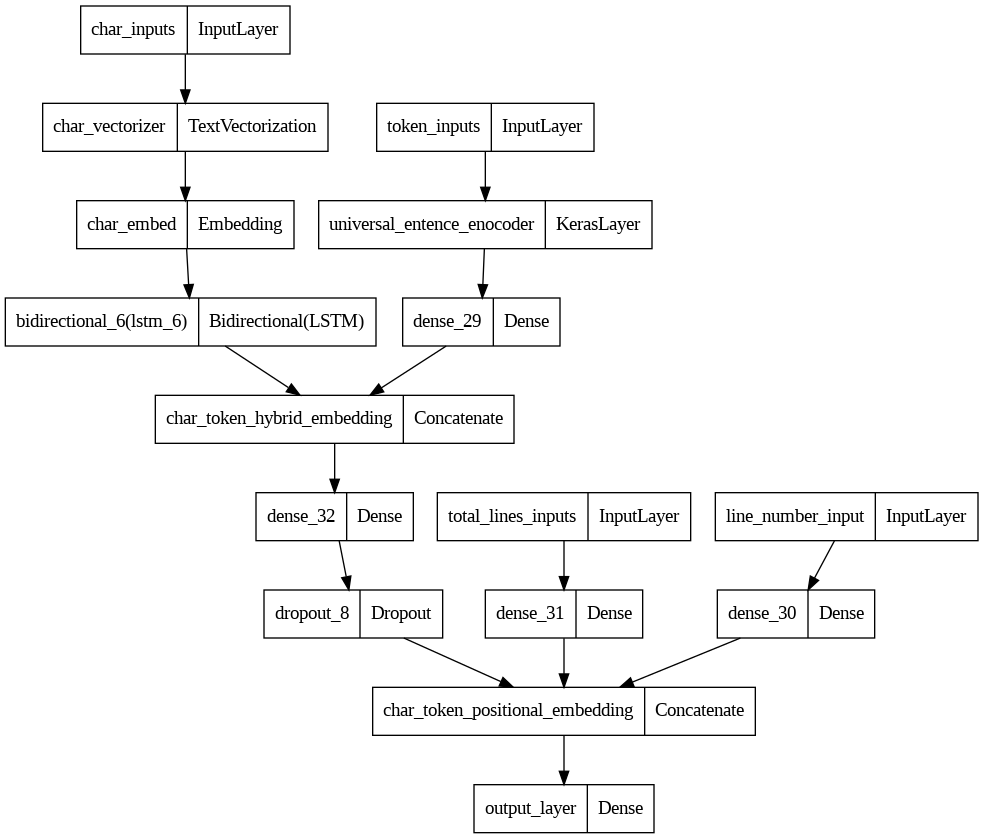

In [213]:
#plot the model architecture
plot_model(model_5)

what is label smoothing?

for example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classses...

really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

what label smoothing does is it assigns some of the value from the highest pred prob to the other classes, in turn, hopefully improving generalization.
`[0.01, 0.01, 0.96, 0.01, 0.01]`

In [214]:
# Compile token, char, and positional embeddings model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### create tribid embedding datasets

In [215]:
#create training dataset with all the 4 kinds of data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [216]:
#create validation dataset with all the 4 kinds of data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [217]:
history_5 = model_5.fit(x = train_char_token_pos_dataset,
                        steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                        epochs = 3,
                        validation_data = val_char_token_pos_dataset,
                        validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 57ms/step - loss: 1.0908 - accuracy: 0.7306 - val_loss: 0.9845 - val_accuracy: 0.8035
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9679 - accuracy: 0.8151 - val_loss: 0.9495 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9506 - accuracy: 0.8227 - val_loss: 0.9376 - val_accuracy: 0.8308


In [218]:
#evaluate
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.9360 - accuracy: 0.8341


[0.9359892010688782, 0.8340725302696228]

In [222]:
#make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 [==============================] - 18s 19ms/step


array([[0.48715764, 0.12355485, 0.01131618, 0.3577326 , 0.02023881],
       [0.5580532 , 0.07059149, 0.03320215, 0.32894057, 0.00921257],
       [0.33338308, 0.09367241, 0.13206412, 0.37160367, 0.06927662],
       ...,
       [0.04080357, 0.1203411 , 0.04641487, 0.03514029, 0.7573002 ],
       [0.03337621, 0.3315389 , 0.07756574, 0.02365922, 0.5338599 ],
       [0.2243475 , 0.5457079 , 0.13678327, 0.03052873, 0.06263269]],
      dtype=float32)

In [223]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1
                          )
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [225]:
#calculate results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.4072553952072,
 'precision': 0.8328766069949073,
 'recall': 0.834072553952072,
 'f1': 0.8329089493782668}